In [1]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gLV
# from mimic.model_infer import *
from mimic.model_simulate import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc as pm
import arviz as az
from pymc.ode import DifferentialEquation
from mimic.model_simulate.sim_CRM import sim_CRM
import pytensor.tensor as at


## Simulate some time course data from the CRM

The McArthur Consumer Resource Model takes the form


$$ dN_i/dt = 1/\tau_i N_i (\sum_a(c_{ia} w_a R_a - m_i)) $$
$$ dR_a/dt = 1/(r_a K_a) (K_a - R_a) R_a - \sum_i(N_i c_{ia} R_a) $$

where:
-   $N_i$ is the concentration of a species
-  $R_a$ is the concentration of a resource
-  $c_{ia}$ is the preference of species $i$ for resource $a$
- $w_a$ is the quality of resource $a$
-  $m_i$ is the mortality rate of species $i$
- $K_a$ is the carrying capacity of resource $a$
- $\tau_i$ is the timescale of species $i$
- $r_a$ is the timescale of resource $a$

### Generate parameters for model with two species

In [2]:
set_all_seeds(1234)

num_species = 2
num_resources = 2
times = np.arange(0, 10, 0.1)

# species timescales
tau = np.random.uniform(0.1, 1.0, num_species)

# resource quality
w = np.random.uniform(0.1, 1.0, num_resources)

# relative resource preferences
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))

# mortality rates
m = np.random.uniform(0.1, 1.0, num_species)

# resource timescales
r = np.random.uniform(0.1, 1.0, num_resources)

# resource carrying capacities
K = np.random.uniform(1.0, 10.0, num_resources)

# write the mu, M, epsilon, and pert_fn to a dictionary and pickle
params = {'num_species': num_species, 'num_resources': num_resources, 'tau': tau, 'w': w, 'c': c, 'm': m, 'r': r, 'K': K}
pd.to_pickle(params, 'params-s5.pkl')


### Simulate single time course

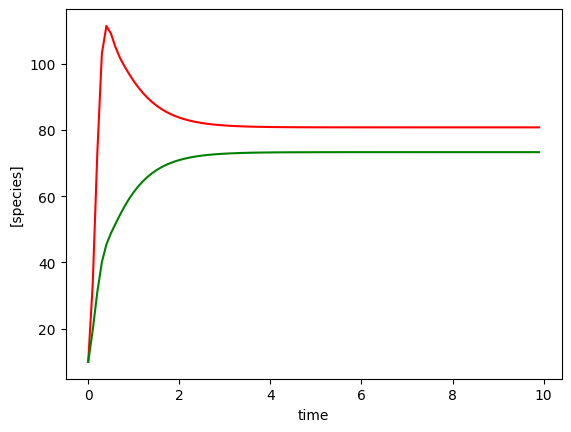

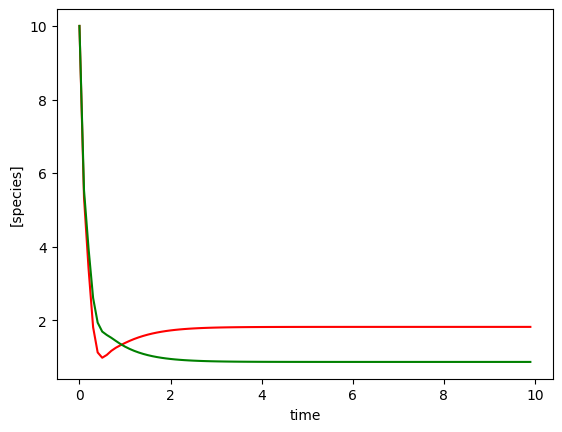

In [3]:


# initial conditions
init_species = 10 * np.ones(num_species+num_resources)

# instantiate simulator
simulator = sim_CRM(num_species=num_species,
                    num_resources=num_resources)

simulator.set_parameters(num_species = params['num_species'],
                         num_resources = params['num_resources'],
                         tau = params['tau'],
                         w = params['w'],
                         c = params['c'],
                         m = params['m'],
                         r = params['r'],
                         K = params['K'])

simulator.print_parameters()

observed_species, observed_resources = simulator.simulate(times, init_species)
observed_data = np.hstack((observed_species, observed_resources))
 
# plot species simulation
plot_gLV(observed_species, times)

# plot resources simulation
plot_gLV(observed_resources, times)


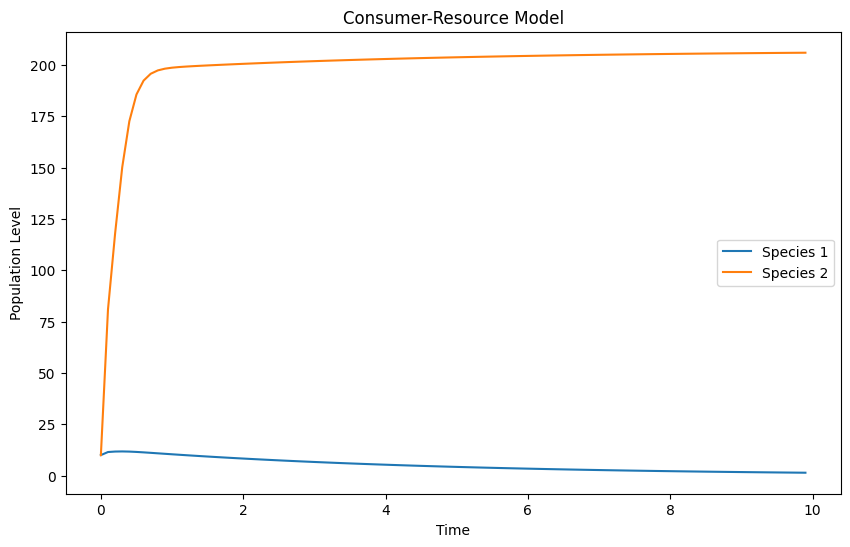

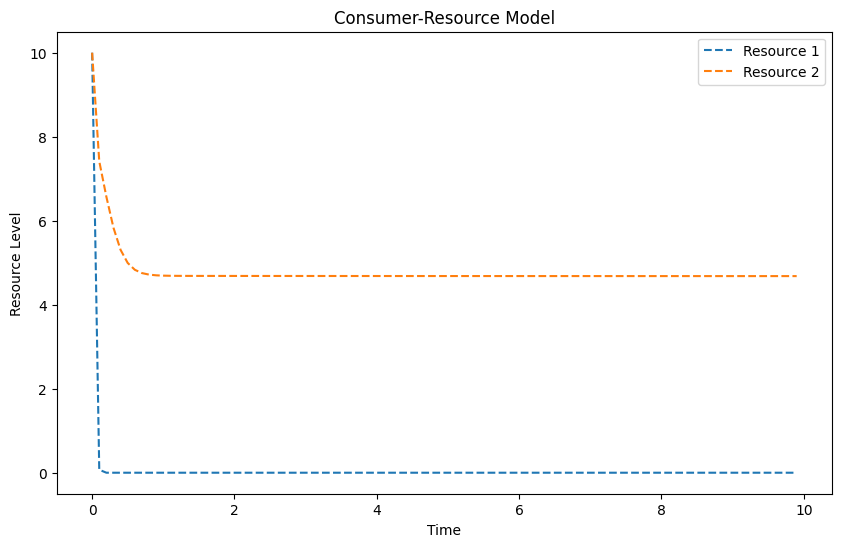

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def CRM(sy, t, nsp, nr, tau, w, c, m, r, K):
    # Separate species (N) and resources (R)
    N = sy[:nsp]
    R = sy[nsp:]

    # Changes in species (dN)
    dN = (N / tau) * (c @ (w * R) - m)

    # Changes in resources (dR)
    dR = (1 / r * K) * (K - R) * R - (N @ c * R)

    # Return derivative of species and resources
    return np.hstack((dN, dR))


# Parameters for the model
nsp = 2  # Number of species
nr = 2   # Number of resources


tau = np.random.uniform(0.1, 1.0, nsp)  # species timescales
w = np.random.uniform(0.1, 1.0, nr)    # resource quality
c = np.random.uniform(0.1, 1.0, (nsp, nr))  # relative resource preferences
m = np.random.uniform(0.1, 1.0, nsp)  # mortality rates
r = np.random.uniform(0.1, 1.0, nr)   # resource timescales
K = np.random.uniform(1.0, 10.0, nr)  # resource carrying capacities


# Initial conditions (N0 for species, R0 for resources)
N0 = np.array([5.0, 4.0])  # Initial species populations
R0 = np.array([50.0, 50.0])  # Initial resource amounts
sy0 = np.concatenate([N0, R0])  # Combined initial condition
init_species = 10 * np.ones(nsp + nr)


# Time points to solve the ODE
times = np.arange(0, 10, 0.1)

# Solve the system of ODEs
solution = odeint(CRM, init_species, times, args=(nsp, nr, tau, w, c, m, r, K))

# Extract species and resources from the solution
N_solution = solution[:, :nsp]  # Species population over time
R_solution = solution[:, nsp:]  # Resource levels over time

# Plot the results

# Plot species populations over time
plt.figure(figsize=(10, 6))
for i in range(nsp):
    plt.plot(times, N_solution[:, i], label=f"Species {i+1}")


plt.xlabel("Time")
plt.ylabel("Population Level")
plt.legend()
plt.title("Consumer-Resource Model")
plt.show()



# Plot resource levels over time
plt.figure(figsize=(10, 6))
for j in range(nr):
    plt.plot(times, R_solution[:, j], label=f"Resource {j+1}", linestyle='--')

plt.xlabel("Time")
plt.ylabel("Resource Level")
plt.legend()
plt.title("Consumer-Resource Model")
plt.show()

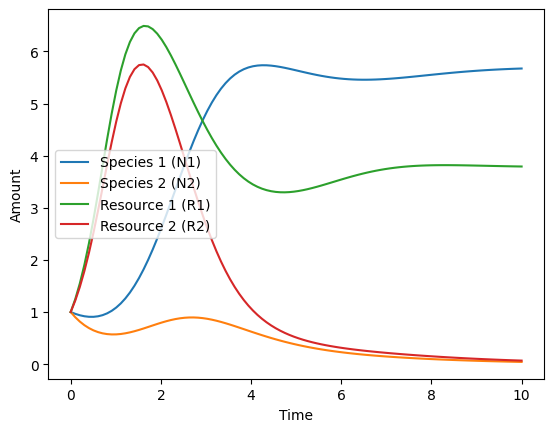

In [13]:

import numpy as np
import pymc as pm
from pymc.ode import DifferentialEquation

# Define the ODE function for CRM model
def CRM(y,t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]  # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)

    
    # Species growth equation (dN)
    #dN = (N / tau) * (c @ (w * R) - m)  # Species growth equation

    growth_term = at.dot(c, w * R)  # Matrix multiplication for species-resource interaction
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    #dR = (1 / r * K) * (K - R) * R - (N @ c * R) # Resource consumption

    consumption_term = at.dot(N, c)  # Matrix multiplication for resource consumption by species
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   

    # Return the derivatives for both species and resources as a single array
    #return np.concatenate([dN, dR])  # Concatenate to match n_states
    #return [dN,dR] 
    return derivatives  # Return as list

def CRM_numeric(y,t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]  # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)


    #dN = (N / tau) * (c @ (w * R) - m)  # Species growth equation

    #dR = (1 / r * K) * (K - R) * R - (N @ c * R) # Resource consumption

    # Species growth equation (dN)
    growth_term = np.dot(c, w * R)  # Matrix multiplication for species-resource interaction
    dN = (N / tau) * (growth_term - m)  # Species growth equation

    # Resource consumption equation (dR)
    consumption_term = np.dot(N, c)  # Matrix multiplication for resource consumption by species
    dR = (1 / (r * K)) * (K - R) * R - consumption_term * R  # Resource consumption equation

    # Combine dN and dR into a single 1D array
    derivatives = [dN[0], dN[1], dR[0], dR[1]]  # Horizontal stacking ensures a 1D array
   

    # Return the derivatives for both species and resources as a single array
    #return np.concatenate([dN, dR])  # Concatenate to match n_states
    #return [dN,dR] 
    return derivatives  # Return as list
    

# Set up initial conditions and parameters
num_species = 2
num_resources = 2

# Define model parameters (totals for species and resources)
# Set initial values for parameters (these would be set as priors later on)
tau = np.random.uniform(0.1, 1.0, num_species)  # Species time scales (2 values)
w = np.random.uniform(0.1, 1.0, num_resources)  # Resource quality (2 values)
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))  # Resource preferences (2x2 matrix)
c_flat = c.ravel()  # Flatten the matrix for PyMC input
m = np.random.uniform(0.1, 1.0, num_species)  # Mortality rates (2 values)
r = np.random.uniform(0.1, 1.0, num_resources)  # Resource time scales (2 values)
K = np.random.uniform(1.0, 10.0, num_resources)  # Resource carrying capacities (2 values)

# Store parameters in a single vector (flattened for PyMC input)
params = np.concatenate([tau, w, c_flat, m, r, K])

# Set initial conditions (initial populations of species and resources)
y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations
initial_conditions = np.concatenate([np.array([5.0, 2.0]), np.array([8.0, 12.0])])


# Time points for integration
times = np.linspace(0, 10, 100)

from scipy.integrate import odeint
numeric_solution = odeint(CRM_numeric, y0=y0, t=times, args=(params,))
#plt.plot(times, numeric_solution)
#plt.show()

# Plot the solution
plt.plot(times, numeric_solution[:, 0], label='Species 1 (N1)')
plt.plot(times, numeric_solution[:, 1], label='Species 2 (N2)')
plt.plot(times, numeric_solution[:, 2], label='Resource 1 (R1)')
plt.plot(times, numeric_solution[:, 3], label='Resource 2 (R2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()


# Define the DifferentialEquation model
crm_model = DifferentialEquation(
    func=CRM,  # The ODE function
    times=times,  # Time points for the solution
    n_states=num_species+num_resources,  # Total state variables (2 species + 2 resources)
    n_theta=len(params),  # Total number of parameters (tau, w, c, m, r, K)
    t0=0  # Initial time
)






In [15]:
nr = num_resources
nsp = num_species
n_states = nsp + nr

with pm.Model() as model:
    # Priors for the parameters
    sigma = pm.HalfCauchy("sigma", 1, shape=n_states)  
    
    tau = pm.Normal("tau", mu=1.0, sigma=0.5, shape=nsp)
    w = pm.Normal("w", mu=1.0, sigma=0.2, shape=nr)
    c = pm.Normal("c", mu=0.5, sigma=0.1, shape=(nsp, nr))
    m = pm.Normal("m", mu=0.1, sigma=0.05, shape=nsp)
    r = pm.Normal("r", mu=1.0, sigma=0.1, shape=nr)
    K = pm.Normal("K", mu=10.0, sigma=5.0, shape=nr)

    # Pack parameters into a single vector
    theta = at.concatenate([tau, w, c.flatten(), m, r, K])

    # Initial conditions for the ODE
    initial_conditions = np.concatenate([np.array([5.0, 2.0]), np.array([8.0, 12.0])])
    y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations

    # Solve the ODE
    crm_curves = crm_model(y0=y0, theta=theta)

    # Define the likelihood
    Y = pm.Lognormal("Y", mu=at.log(crm_curves), sigma=sigma, observed=numeric_solution)

    # Sample the posterior
    data = pm.sample(draws = 50, tune=50, chains =1, cores=2)

az.plot_posterior(data)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, tau, w, c, m, r, K]


Output()

/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/pymc/ode/ode.py:133: ODEintWarning: 
Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(

Sampling 1 chain for 50 tune and 1 draw iterations (50 + 1 draws total) took 1089 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.
/Users/chaniaclare/Documents/GitHub/MIMIC/venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'K\n0'}>,
        <Axes: title={'center': 'K\n1'}>,
        <Axes: title={'center': 'c\n0, 0'}>],
       [<Axes: title={'center': 'c\n0, 1'}>,
        <Axes: title={'center': 'c\n1, 0'}>,
        <Axes: title={'center': 'c\n1, 1'}>],
       [<Axes: title={'center': 'm\n0'}>,
        <Axes: title={'center': 'm\n1'}>,
        <Axes: title={'center': 'r\n0'}>],
       [<Axes: title={'center': 'r\n1'}>,
        <Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>],
       [<Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>,
        <Axes: title={'center': 'tau\n0'}>],
       [<Axes: title={'center': 'tau\n1'}>,
        <Axes: title={'center': 'w\n0'}>,
        <Axes: title={'center': 'w\n1'}>]], dtype=object)

ValueError: Image size of 1746x131600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2208x3312 with 18 Axes>

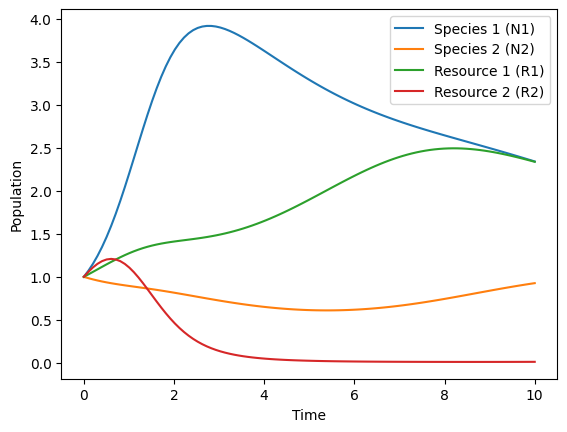

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE function for CRM model
def CRM(y, t, p):
    # Unpack parameters from the vector p
    tau = p[:2]  # Species time scales (2 values)
    w = p[2:4]   # Resource quality (2 values)
    c_flat = p[4:8]  # Flattened resource preferences (4 values)
    c = c_flat.reshape((2, 2))  # Reshape to 2x2 matrix
    m = p[8:10]  # Mortality rates (2 values)
    r = p[10:12]  # Resource time scales (2 values)
    K = p[12:14]  # Resource carrying capacities (2 values)

    # Separate species (N) and resources (R)
    N = y[:2]  # Species populations (2 elements)
    R = y[2:]  # Resource availability (2 elements)

    # Define the ODEs
    dN = (N / tau) * (np.dot(c, w * R) - m)  # Species growth equation
    dR = (1 / (r * K)) * (K - R) * R - np.dot(N, c) * R  # Resource consumption

    # Return the concatenated derivatives
    return np.concatenate([dN, dR])

# Set initial conditions and parameters
num_species = 2
num_resources = 2

# Define model parameters (totals for species and resources)
tau = np.random.uniform(0.1, 1.0, num_species)  # Species time scales (2 values)
w = np.random.uniform(0.1, 1.0, num_resources)  # Resource quality (2 values)
c = np.random.uniform(0.1, 1.0, (num_species, num_resources))  # Resource preferences (2x2 matrix)
c_flat = c.ravel()  # Flatten the matrix for PyMC input
m = np.random.uniform(0.1, 1.0, num_species)  # Mortality rates (2 values)
r = np.random.uniform(0.1, 1.0, num_resources)  # Resource time scales (2 values)
K = np.random.uniform(1.0, 10.0, num_resources)  # Resource carrying capacities (2 values)

# Store parameters in a single vector (flattened for PyMC input)
params = np.concatenate([tau, w, c_flat, m, r, K])

# Set initial conditions (initial populations of species and resources)
y0 = np.concatenate([np.ones(num_species), np.ones(num_resources)])  # Initial species and resource populations

# Time points for integration
times = np.linspace(0, 10, 100)

# Solve the ODE using odeint
solution = odeint(CRM, y0=y0, t=times, args=(params,))

# Plot the solution
plt.plot(times, solution[:, 0], label='Species 1 (N1)')
plt.plot(times, solution[:, 1], label='Species 2 (N2)')
plt.plot(times, solution[:, 2], label='Resource 1 (R1)')
plt.plot(times, solution[:, 3], label='Resource 2 (R2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


## Example SIR model

In [61]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]


times = np.arange(0, 5, 0.25)

beta, gamma = 4, 1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$S(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$I(t)$")
plt.legend()
plt.show()

AttributeError: 'numpy.float64' object has no attribute 'type'

In [ ]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occurred
    R0 = pm.TruncatedNormal("R0", mu=2, sigma=3, lower=1)
    lam = pm.Lognormal("lambda", pm.math.log(2), 2)
    beta = pm.Deterministic("beta", lam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

    data = pm.sample(draws = 20, tune=20, chains = 2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, R0, lambda]


Output()

ValueError: Not enough samples to build a trace.

array([[<Axes: title={'center': 'R0'}>, <Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>, <Axes: >]], dtype=object)

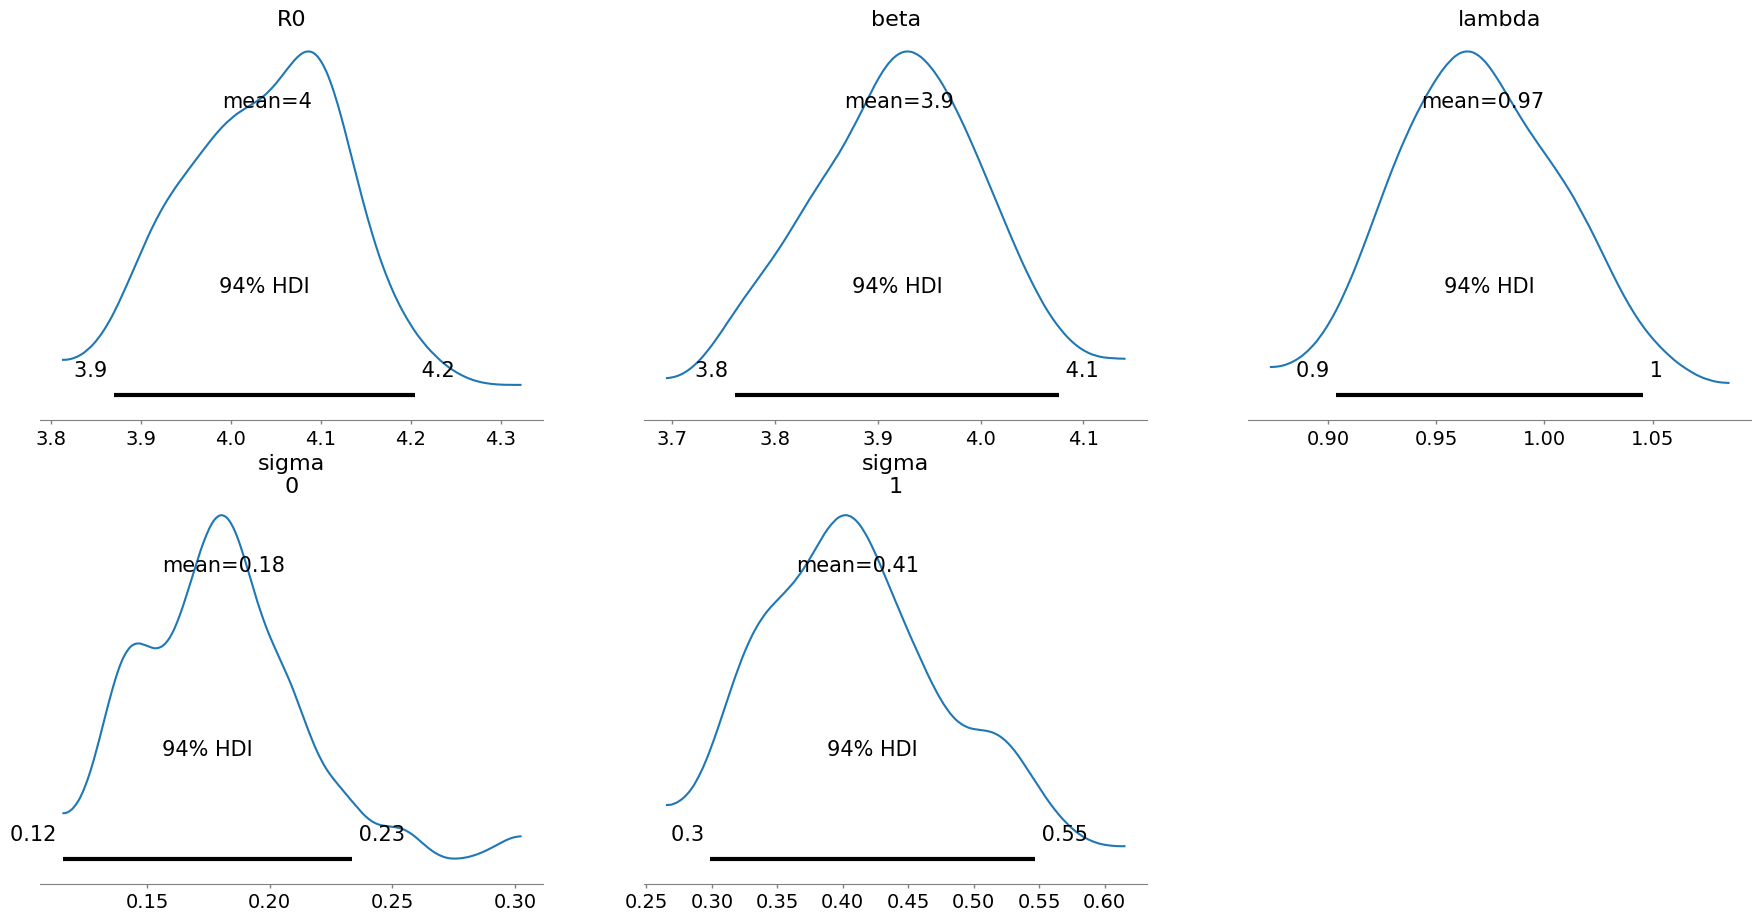

In [17]:
az.plot_posterior(data)